# Notes on Computing the Rollout Acquisition Function
## Considerations
- Incorporate control variates for variance reduction on rollout acquisition function
- Give further consideration for the construction of arbitrary kernels and maintaining which hyperparameters belong to which kernels. I think we can borrow from the `Multi-Fidelity Bayesian Optimization` repository. I need to treat scaling of kernels as creating a kernel object with a single hyperparameter and multiply this `ScaleKernel` against the other kernel.

## What I'm Doing
- [x] Remove conditioning fantasized surrogate on gradient samples
- [ ] Write a method for estimating the acquisition function using forward mode differentation

We have a few ways of computing surrogate perturbations. One relies on computing perturbations of our `RBFsurrogate` with the data and spatial perturbations performed jointly. One relies on `FantasySurrogate` which leverages smart indexing to compute perturbations of data and spatial locations independently. The final one is wrt to `SmartFantasyRBFsurrogate` which does them idenpendtly as well.

## Augmentations
- [x] Consider reusing the same trajectory object inplace to avoid allocations.
- [x] Incorporate gradient information for MLE estimation of kernel hyperparameters.
- [x] Reuse surrogate construction for computing gradient information
- [x] Add functional API for interacting with kernel objects. Too many direct accesses.
- [ ] Try augmenting the optimization of the decision rule to reuse sx computation
- [ ] Use a line search method for inner optimization

In [1]:
using Profile
using ProfileView

All the necessary imports for our computations of interest

In [2]:
include("../rollout_bayesian_optimization.jl")

deterministic_solve (generic function with 1 method)

## Basic Setup

In [3]:
# Visualize 1D test function
testfn = TestLinearCosine1D(1., 9.2, lb=-1, ub=1.)
# testfn = TestConstant(lbs=[0.], ubs=[1.])
# testfn = TestQuadratic1D()
# tplot(testfn)

TestFunction(1, [-1.0 1.0], ([0.0],), var"#f#89"{Float64, Float64}(1.0, 9.2), var"#∇f#90"{Float64, Float64}(1.0, 9.2))

In [9]:
MC_SAMPLES = 500
NUMBER_OF_STARTS = 8
HORIZON = 2
USE_LDS = true
INITIAL_SAMPLES = 3
BUDGET = 5

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
θinit = [0.0]
# ψ = kernel_scale(Matern52, [5., .25])
ψ = Matern52()

lbs, ubs = get_bounds(testfn)
midpoint = (ubs + lbs) / 2
domain = dense_1D_discretization(lb=first(lbs), ub=first(ubs), stepsize=.01)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    start=midpoint,
    horizon=HORIZON,
    mc_iterations=MC_SAMPLES,
    use_low_discrepancy_sequence=USE_LDS,
    spatial_lowerbounds=lbs,
    spatial_upperbounds=ubs,
    hypers=θinit
)
es = ExperimentSetup(number_of_starts=NUMBER_OF_STARTS, tp=tp);

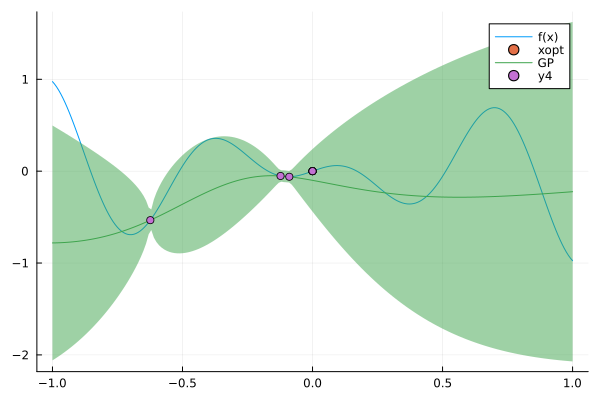

In [5]:
Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
yinit = testfn(Xinit)
sur = Surrogate(ψ, Xinit, yinit, decision_rule=EI(), σn2=σn2, capacity=BUDGET + INITIAL_SAMPLES)
optimize!(sur, lowerbounds=[.1], upperbounds=[3.])
fsur = FantasySurrogate(sur, HORIZON)
T = Trajectory(sur, fsur, start=midpoint, hypers=θinit, horizon=HORIZON)

tplot(testfn)
plot!(domain, [sur([x], θinit).μ for x in domain], ribbons=2sqrt.([sur([x], θinit).σ for x in domain]), label="GP")
scatter!(sur.X', sur.y)

## Visualizing Base Policy Solves along a Trajectory

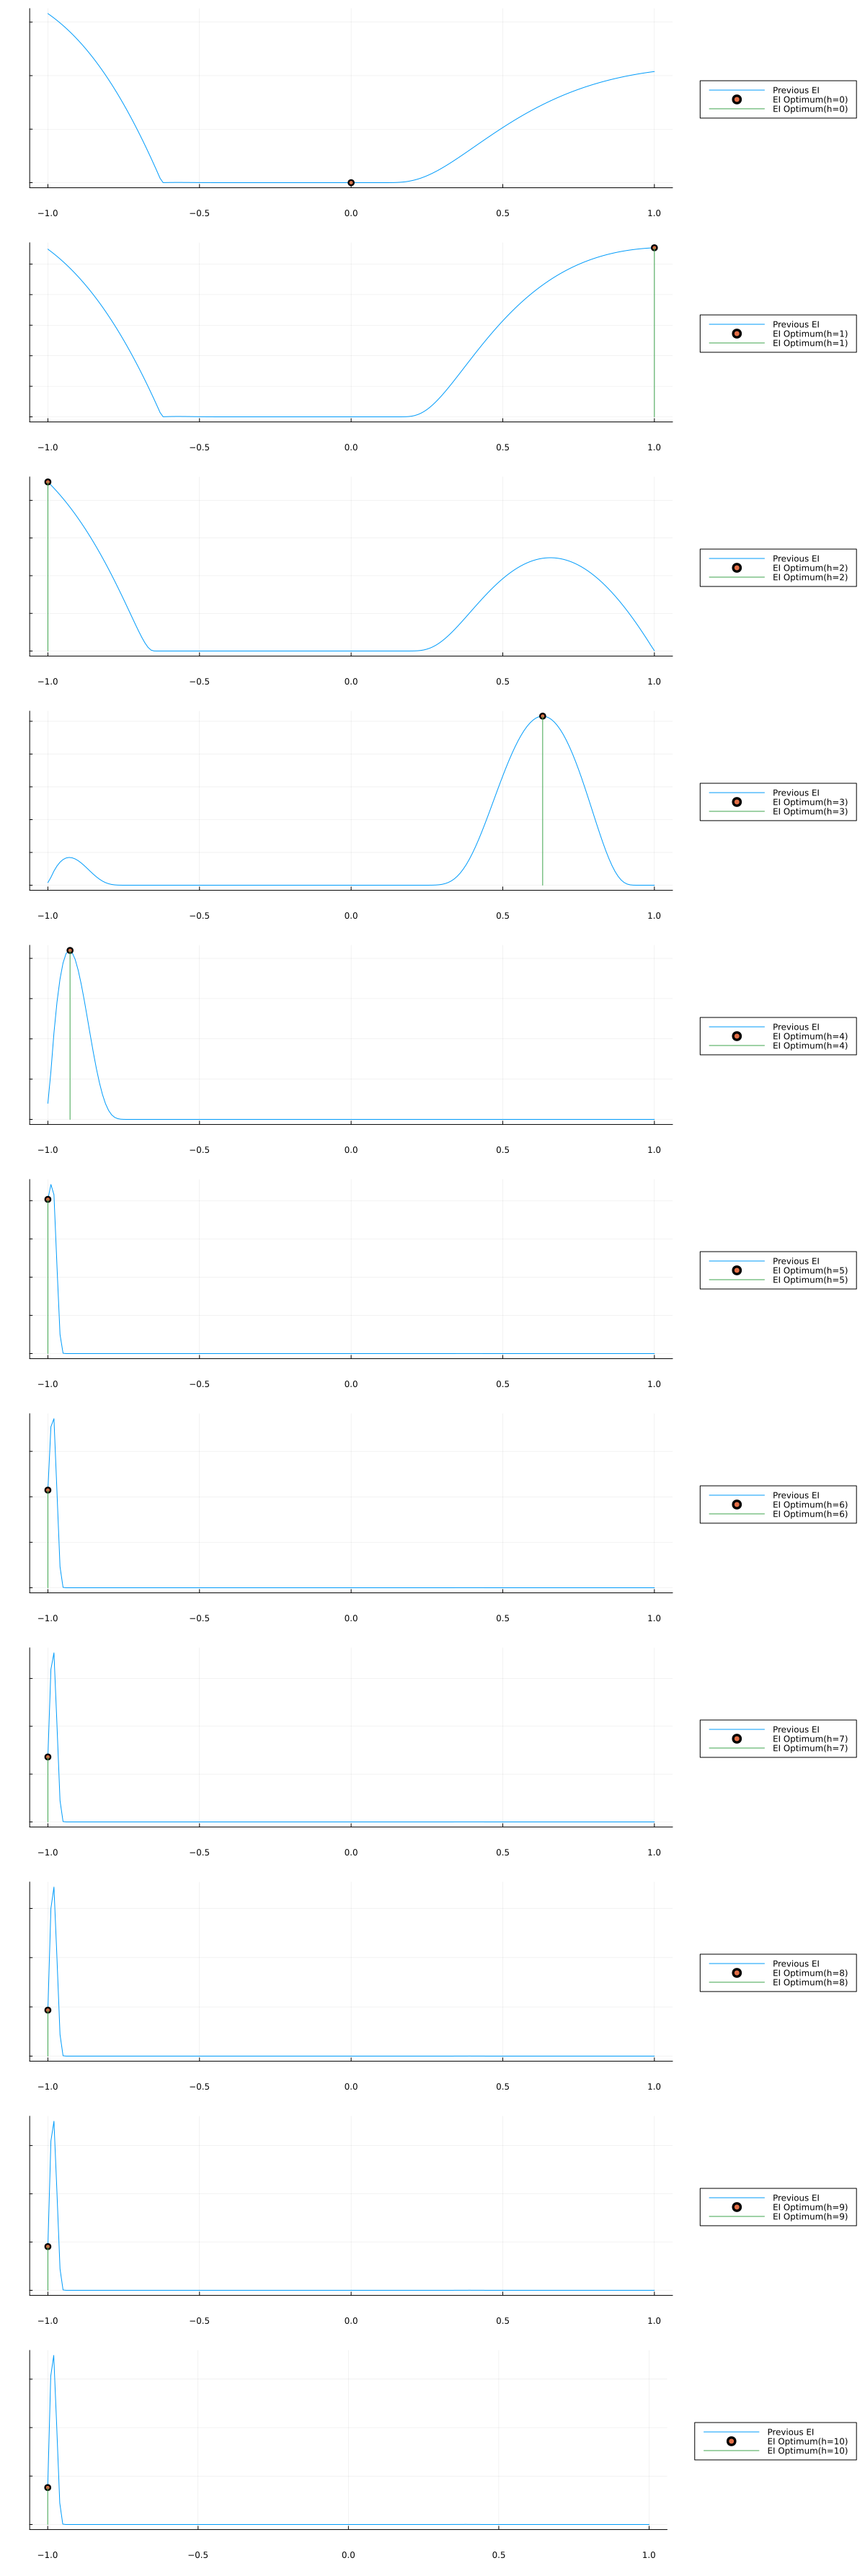

In [8]:
IS_DETERMINISTIC = false

# Construct trajectory
AT = Trajectory(
    sur,
    fsur,
    start=get_starting_point(tp),
    hypers=get_hyperparameters(tp),
    horizon=get_horizon(tp)
)
stochastic_sampler = StochasticObservable(
    surrogate=get_fantasy_surrogate(AT),
    stdnormal=get_samples_rnstream(tp, sample_index=1),
    max_invocations=get_horizon(tp) + 1
)
deterministic_sampler = DeterministicObservable(
    func=testfn.f,
    gradient=testfn.∇f,
    max_invocations=get_horizon(tp) + 1
)
attach_observable!(AT, IS_DETERMINISTIC ? deterministic_sampler : stochastic_sampler)
# Adjoint Rollout
rollout!(
    AT,
    lowerbounds=lbs,
    upperbounds=ubs,
    xstarts=get_starts(es),
    get_observation=get_observable(AT)
)

all_plots = []

for upto_index in 0:HORIZON
    EIx = zeros(length(domain))
    for (i, xx) in enumerate(domain)
        EIx[i] = eval(AT.fs([xx], θinit, fantasy_index=upto_index-1))
    end
    p = plot(domain, EIx, label="Previous EI")
    target_location = first(AT.fs.X[:, INITIAL_SAMPLES + upto_index + 1])
    
    scatter!(
        [target_location],
        [eval(AT.fs([target_location], θinit, fantasy_index=upto_index-1))],
        label="EI Optimum(h=$upto_index)"
    )
    
    plot!(
        [target_location, target_location],
        [0., eval(AT.fs([target_location], θinit, fantasy_index=upto_index-1))],
        label="EI Optimum(h=$upto_index)"
    )
    push!(all_plots, p)
end

plot(all_plots..., layout=(length(all_plots), 1), size=(1200, 325 * (HORIZON + 1)), legend=:outerright)

In [28]:
etos = []
forward_etos = []
fd_etos = []
resolutions = zeros(MC_SAMPLES)
gresolutions = zeros(testfn.dim, MC_SAMPLES)
h = 1e-6

for (index, xx) in enumerate(domain)
    print("|")
    # Adjoint
    set_starting_point!(tp, [xx])
    eto = simulate_adjoint_trajectory(
        sur,
        fsur,
        tp,
        inner_solve_xstarts=get_starts(es),
        resolutions=get_container(es, symbol=:f),
        spatial_gradients_container=get_container(es, symbol=:grad_f),
        hyperparameter_gradients_container=get_container(es, symbol=:grad_hypers)
    )
    
    push!(etos, eto)

    # Finite Difference
    set_starting_point!(tp, [xx + h])
    etop = simulate_adjoint_trajectory(
        sur,
        tp,
        inner_solve_xstarts=get_starts(es),
        resolutions=get_container(es, symbol=:f),
        spatial_gradients_container=get_container(es, symbol=:grad_f),
        hyperparameter_gradients_container=get_container(es, symbol=:grad_hypers)
    )
    set_starting_point!(tp, [xx - h])
    etom = simulate_adjoint_trajectory(
        sur,
        tp,
        inner_solve_xstarts=get_starts(es),
        resolutions=get_container(es, symbol=:f),
        spatial_gradients_container=get_container(es, symbol=:grad_f),
        hyperparameter_gradients_container=get_container(es, symbol=:grad_hypers)
    )
    push!(fd_etos, (etop, etom))

    # Forward Trajectory
    set_starting_point!(tp, [xx])
    eto = simulate_trajectory(
        osur,
        tp,
        xstarts=get_starts(es),
        resolutions=get_container(es, symbol=:f),
        gradient_resolutions=get_container(es, symbol=:grad_f)
    )
    push!(forward_etos, eto)
end

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

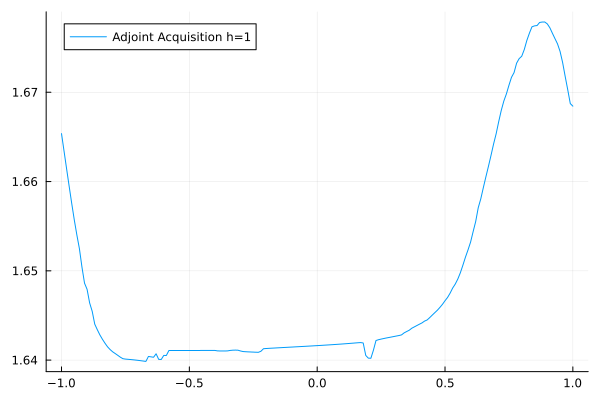

In [30]:
plot(
    domain,
    [mean(eto) for eto in etos],
    # ribbons=[std(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Adjoint Acquisition h=$(get_horizon(tp))"
)
# plot!(
#     domain,
#     [eto[1] for eto in forward_etos],
#     # ribbons=[std(eto) / sqrt(MC_SAMPLES) for eto in etos],
#     label="Forward Acquisition h=$(get_horizon(tp))"
# )

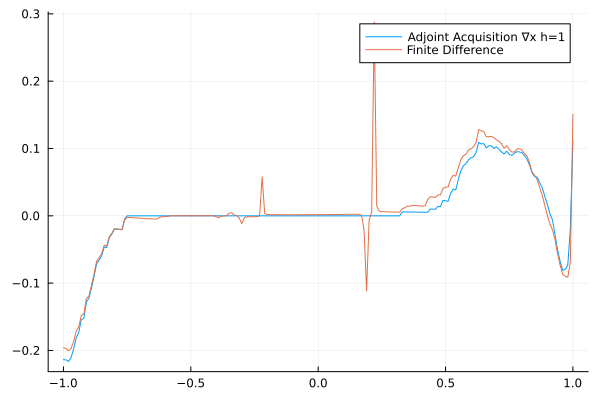

In [33]:
plot(
    domain,
    [(first ∘ gradient)(eto) for eto in etos],
    # ribbons=[(first ∘ std_gradient)(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Adjoint Acquisition ∇x h=$(get_horizon(tp))"
)
# plot!(
#     domain,
#     [eto[2] for eto in forward_etos],
#     # ribbons=[(first ∘ std_gradient)(eto) / sqrt(MC_SAMPLES) for eto in etos],
#     label="Forward Acquisition ∇x h=$(get_horizon(tp))"
# )

tpe, tme = similar(domain), similar(domain)
for (i, (etop, etom)) in enumerate(fd_etos)
    tpe[i] = mean(etop)
    tme[i] = mean(etom)
end

plot!(
    domain,
    (tpe - tme) ./ 2h,
    # ribbons=[(first ∘ std_gradient)(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Finite Difference"
)

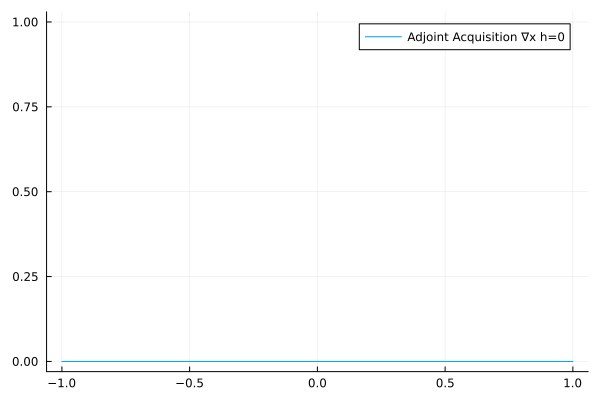

In [14]:
plot(
    domain,
    [first(gradient(eto, wrt_hypers=true)) for eto in etos],
    # ribbons=[(first ∘ std_gradient)(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Adjoint Acquisition ∇x h=$(get_horizon(tp))"
)

In [17]:
# eto = simulate_adjoint_trajectory(
#         sur,
#         fsur,
#         tp,
#         inner_solve_xstarts=get_starts(es),
#         resolutions=get_container(es, symbol=:f),
#         spatial_gradients_container=get_container(es, symbol=:grad_f),
#         hyperparameter_gradients_container=get_container(es, symbol=:grad_hypers)
# )

In [19]:
@timed AdjointTrajectory(
    sur,
    start=get_starting_point(tp),
    hypers=get_hyperparameters(tp),
    horizon=get_horizon(tp)
)

(value = AdjointTrajectory(Surrogate{RBF = RadialBasisFunction{Float64}}, FantasySurrogate{RBF = RadialBasisFunction{Float64}}, [0.0], [0.0], 1, missing), time = 0.000121125, bytes = 3744, gctime = 0.0, gcstats = Base.GC_Diff(3744, 0, 0, 10, 0, 0, 0, 0, 0))